In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def Normalizar(learray):
    final = np.array(learray[:,-1])
    promedio = np.mean(learray,axis=0)
    deviacion = np.std(learray,axis=0)
    for i in range(0,learray.shape[0]):
        learray[i] = np.true_divide((learray[i]-promedio),deviacion)
    learray[:,-1] = final[:]
    return learray


def Leer_Datos(Ruta, delmt ='\t', head = None, col=""):
    data = pd.read_csv(Ruta,delimiter = delmt, header = head,dtype=np.float64)
    data = data.sort_values(by=[col])
    return  data.values


def Leer_Datos2(Ruta, delmt = '\t',head = None):
    datos = pd.read_csv(Ruta, delimiter = delmt, header = head , dtype=np.float64)
    return datos.values



TypeError: Leer_Datos() got an unexpected keyword argument 'sep'

In [59]:
# Todo lo de folds 

def Crear_folds(data,k=3):
    #posiciones = np.where(np.diff(data[:,-1]))
    #print(posiciones)
    ceros, unos = np.split(data,np.where(np.diff(data[:,-1]))[0]+1)
    result =list()
    fold_B1 = np.array_split(ceros,k)
    fold_B2 = np.array_split(unos,k)
    for i in range(k):
        aux = np.concatenate((fold_B1[i],fold_B2[i]))
        np.random.shuffle(aux)
        result.append(aux)
    
  
    return result
    

def guardar_folds(fold_b, nombre,file='/',delt='\t' ):
    for i in range(len(fold_b)):
        archivo = file + nombre + str(i+1)+'.csv'
        np.savetxt(archivo,fold_b[i],delimiter ='\t')
                   
                   
def leer_folds(nombre,delt='\t',k=3):
    nombre = 'Folds/' + nombre
    list_folds = list()
    for i in range(k):
        leer = Leer_Datos2(nombre+str(i+1)+'.csv',delmt=delt)
        list_folds.append(leer)
    return list_folds
    


In [58]:
def Sigmodial(X, theta):
    hipotesis = X.dot(theta.T)
    z = 1/(1+np.exp(-hipotesis))
    return z

def Calcular_costo(X,Y,theta):
    tam = len(X)
    hipotesis = (Sigmodial(X,theta))
    a = np.log(hipotesis) * Y
    b = np.log(1-hipotesis)*(1-Y)
    costo = np.sum(a+b)*(-1/tam)
    return costo


def Gradiente(X,Y,theta):
    tam = len(X)
    hipotesis = Sigmodial(X,theta)
    resta = hipotesis - Y
    derivada = np.dot(X.T, resta) / tam
    return derivada

def Gradiente_descendiente(X,Y,theta,iteraciones,tasa):
    costos = [0]*iteraciones
    for i in range(iteraciones):
        derivada = Gradiente(X,Y,theta)
        theta = theta -(tasa * derivada).T
        costos[i] = Calcular_costo(X,Y,theta)
    return theta,costos
    




In [61]:
# Acurracy
def Accuracy(X,Y,theta):
    y_p = np.rint(Sigmodial(X,theta))
    cont = 0
    for i in (Y-y_p):
        if(i==0):
            cont = cont+1
    porcentaje = (cont/len(Y))*100
    return porcentaje

def Calcular_entrenamientos(folds,val,k=3):
    train =np.array([])
    test =np.array([])
    
    for i in range(k):
        if i in val:
            if len(test) == 0:
                test = folds[i]
            else:
                test = np.concatenate((test,folds[i]))
        else:
            if len(train) == 0:
                train = folds[i]
            else:
                train = np.concatenate((train,folds[i]))
    return train,test


def Agregacion(tests,trains):
    train_x = trains[:,0:-1]
    test_x =  tests[:,0:-1]
    
    train_y = trains[0:,-1:]
    test_y = tests[:,-1:]
    
    train_x = np.insert(train_x,0,1,axis=1)
    test_x = np.insert(test_x,0,1,axis=1)
    
    return train_x, test_x, train_y, test_y



In [56]:
# Lectura de datos 
archivo_diabetes = Leer_Datos("DataSetLog/diabetes.csv",delmt='\t',head=0,col='Outcome')
archivo_cardiaco = Leer_Datos("DataSetLog/Enfermedad_Cardiaca.csv",delmt='\t',head=0,col='target')

# Normalizacion de datos
diabetes_norm = Normalizar(archivo_diabetes)
cardiaco_norm = Normalizar(archivo_cardiaco)

# creacion de los folds


Folds_diabetes = Crear_folds(diabetes_norm)
Folds_cardiaco = Crear_folds(cardiaco_norm)

#print(Folds_diabetes[0].shape,Folds_diabetes[1].shape,Folds_diabetes[2].shape)
#print(Folds_cardiaco[0].shape,Folds_cardiaco[1].shape,Folds_cardiaco[2].shape)

guardar_folds(Folds_diabetes,'Diabetes','Folds/')
guardar_folds(Folds_cardiaco,'Cardiaco','Folds/')


foldDiabetes =leer_folds('Diabetes')
foldCardiaco =leer_folds('Cardiaco')


In [62]:
 #exeprimeento 1 con disabetes

iteraciones = [500 , 1000, 1500, 2000, 2500, 3000, 3500]
tasa_aprendizaje = [0.01,0.05,0.1,0.2,0.3,0.4]

k=3

matriz_ac =np.random.rand(len(tasa_aprendizaje),len(iteraciones))
parametros = (0,0)
para = (len(tasa_aprendizaje),len(iteraciones))
suma = np.zeros(para)

for k in range(k):
    train_diabetes, test_diabetes = Calcular_entrenamientos(foldDiabetes,[k])
    train_dia_x, test_dia_x, train_dia_y, test_dia_y = Agregacion(test_diabetes, train_diabetes)
    theta_dia = np.zeros(train_dia_x.shape[1])[np.newaxis]
    
    for tasa in range(len(tasa_aprendizaje)):
        for itera in range(len(iteraciones)):
            theta_actual, _ = Gradiente_descendiente(train_dia_x, train_dia_y, theta_dia, iteraciones[itera], tasa_aprendizaje[tasa])
            matriz_ac[tasa,itera] = Accuracy(test_dia_x, test_dia_y, theta_actual)
    aux = matrix_ac
    suma = suma+ matrix_ac
    
    

suma = suma/3

for tasa in range(len(tasa_aprendizaje)):
    for itera in range(len(iteraciones)):
        if(matriz_ac[tasa,itera] > matriz_ac[parametros[0],parametros[1]]):
            parametros = (tasa,itera)

cuadro1 = pd.DataFrame(data = matriz_ac, index = tasa_aprendizaje, columns =iteraciones)
print(cuadro1)
print ("Mayor accuracy en :",tasa_aprendizaje[parametros[0]],iteraciones[parametros[1]])



############################################



           500        1000       1500       2000       2500       3000  \
0.01  72.549020  72.156863  72.941176  72.941176  72.549020  72.549020   
0.05  72.549020  72.941176  72.941176  73.333333  73.333333  73.333333   
0.10  72.941176  73.333333  73.333333  73.333333  73.333333  73.333333   
0.20  73.333333  73.333333  73.333333  73.333333  73.333333  73.333333   
0.30  73.333333  73.333333  73.333333  73.333333  73.333333  73.333333   
0.40  73.333333  73.333333  73.333333  73.333333  73.333333  73.333333   

           3500  
0.01  72.549020  
0.05  73.333333  
0.10  73.333333  
0.20  73.333333  
0.30  73.333333  
0.40  73.333333  
Mayor accuracy en : 0.05 2000


In [51]:
print("resultdo de cardiaco")

iteraciones = [500 , 1000, 1500, 2000, 2500, 3000, 3500]
tasa_aprendizaje = [0.01,0.05,0.1,0.2,0.3,0.4]

k=3



matriz_ac1 =np.random.rand(len(tasa_aprendizaje),len(iteraciones))
parametros_c = (0,0)
para = (len(tasa_aprendizaje),len(iteraciones))
suma = np.zeros(para)

for k in range(k):
    train_cardiaco, test_cardiaco = Calcular_entrenamientos(foldCardiaco,[k])
    train_cardi_x, test_cardi_x, train_cardi_y, test_cardi_y = Agregacion(test_cardiaco, train_cardiaco)
    theta_cardi = np.zeros(train_cardi_x.shape[1])[np.newaxis]
    
    for tasa in range(len(tasa_aprendizaje)):
        for itera in range(len(iteraciones)):
            theta_actual, _ = Gradiente_descendiente(train_cardi_x, train_cardi_y, theta_cardi, iteraciones[itera], tasa_aprendizaje[tasa])
            matriz_ac1[tasa,itera] = Accuracy(test_cardi_x, test_cardi_y, theta_actual)
    aux = matrix_ac
    suma = suma+ matriz_ac1
    
    

suma = suma/3

for tasa in range(len(tasa_aprendizaje)):
    for itera in range(len(iteraciones)):
        if(matriz_ac1[tasa,itera] > matriz_ac[parametros_c[0],parametros_c[1]]):
            parametros_c = (tasa,itera)

cuadro2= pd.DataFrame(data = matriz_ac1, index = tasa_aprendizaje, columns =iteraciones)
print(cuadro2)
print ("Mayor accuracy en :",tasa_aprendizaje[parametros_c[0]],iteraciones[parametros_c[1]])


resultdo de cardiaco
           500        1000       1500       2000       2500       3000  \
0.01  85.148515  83.168317  84.158416  83.168317  83.168317  82.178218   
0.05  83.168317  81.188119  81.188119  81.188119  81.188119  81.188119   
0.10  81.188119  81.188119  81.188119  81.188119  81.188119  81.188119   
0.20  81.188119  81.188119  81.188119  81.188119  81.188119  81.188119   
0.30  81.188119  81.188119  81.188119  81.188119  81.188119  81.188119   
0.40  81.188119  81.188119  81.188119  81.188119  81.188119  81.188119   

           3500  
0.01  82.178218  
0.05  81.188119  
0.10  81.188119  
0.20  81.188119  
0.30  81.188119  
0.40  81.188119  
Mayor accuracy en : 0.4 3500


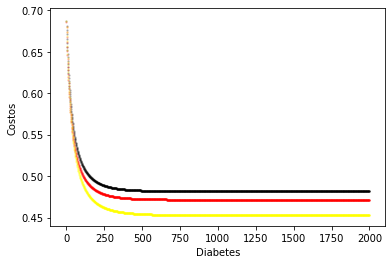

In [66]:
#Experimento 2
colors=["black","red","yellow"]
k=3
#_, costos_d = Gradiente_descendiente(train_dia_x,train_dia_y,theta_dia,iteraciones[parametros[1]],tasa_aprendizaje[parametros[0]])
#_, costos_c = Gradiente_descendiente(train_cardi_x,train_cardi_y,theta_cardi,iteraciones[parametros_c[1]],tasa_aprendizaje[parametros_c[0]])
for k in range(k):
    train_dia_g,test_dia_g = Calcular_entrenamientos(foldDiabetes,[k])
    train_dia_x, test_dia_x,train_dia_y, test_dia_y = Agregacion(test_dia_g,train_dia_g)
    theta_dia_g = np.zeros(train_dia_x.shape[1])[np.newaxis]
    _, costos_d = Gradiente_descendiente(train_dia_x, train_dia_y, theta_dia_g,iteraciones[parametros[1]],tasa_aprendizaje[parametros[0]])
    plt.scatter(np.arange(iteraciones[parametros[1]]),costos_d,alpha=0.2,c=colors[k],s=2)
    plt.xlabel('iteraciones')
    plt.ylabel('Costos')
    plt.xlabel('Diabetes')

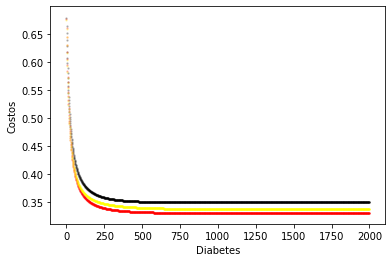

In [67]:
#Experimento 2
colors=["black","red","yellow"]
k=3
#_, costos_d = Gradiente_descendiente(train_dia_x,train_dia_y,theta_dia,iteraciones[parametros[1]],tasa_aprendizaje[parametros[0]])
#_, costos_c = Gradiente_descendiente(train_cardi_x,train_cardi_y,theta_cardi,iteraciones[parametros_c[1]],tasa_aprendizaje[parametros_c[0]])
for k in range(k):
    train_cardi_g,test_cardi_g = Calcular_entrenamientos(foldCardiaco,[k])
    train_cardi_x, test_cardi_x,train_cardi_y, test_cardi_y = Agregacion(test_cardi_g,train_cardi_g)
    theta_cardi_g = np.zeros(train_cardi_x.shape[1])[np.newaxis]
    _, costos_d = Gradiente_descendiente(train_cardi_x, train_cardi_y, theta_cardi_g,iteraciones[parametros[1]],tasa_aprendizaje[parametros[0]])
    plt.scatter(np.arange(iteraciones[parametros[1]]),costos_d,alpha=0.2,c=colors[k],s=2)
    plt.xlabel('iteraciones')
    plt.ylabel('Costos')
    plt.xlabel('Diabetes')